#**Import required Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# We will import plotting libraries later when we need them.

print("Necessary libraries imported.")


Necessary libraries imported.


# **Load** **Datasets**

In [2]:
df_hist = pd.read_csv('historical_data.csv')
df_fgi = pd.read_csv('fear_greed_index.csv')
print("Data loaded successfully.")
print("\n--- Historical Trader Data (df_hist) ---")
print(df_hist.head(2).T.to_markdown())

print("\n--- Fear & Greed Index Data (df_fgi) ---")
print(df_fgi.head(2).to_markdown(index=False))

Data loaded successfully.

--- Historical Trader Data (df_hist) ---
|                  | 0                                                                  | 1                                                                  |
|:-----------------|:-------------------------------------------------------------------|:-------------------------------------------------------------------|
| Account          | 0xae5eacaf9c6b9111fd53034a602c192a04e082ed                         | 0xae5eacaf9c6b9111fd53034a602c192a04e082ed                         |
| Coin             | @107                                                               | @107                                                               |
| Execution Price  | 7.9769                                                             | 7.98                                                               |
| Size Tokens      | 986.87                                                             | 16.0                                           

/tmp/ipython-input-2251113918.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hist = pd.read_csv('historical_data.csv')


# **Cleaning and Standardizing the Date Column**

In [3]:
# 1. Prepare Historical Trader Data
# The 'Timestamp IST' is a string. First, convert it to a proper datetime object.
# Explicitly specify the format based on the error message: DD-MM-YYYY HH:MM
df_hist['Datetime_IST'] = pd.to_datetime(df_hist['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Then, extract ONLY the date part (YYYY-MM-DD) from the full timestamp.
df_hist['Date'] = df_hist['Datetime_IST'].dt.date

# Convert the extracted date back to a datetime object, which is best practice for merging.
df_hist['Date'] = pd.to_datetime(df_hist['Date'])

# 2. Prepare Fear & Greed Index Data
# Rename the column for clarity and ensure it's a datetime object.
df_fgi.rename(columns={'date': 'Date', 'value': 'FGI_Value', 'classification': 'FGI_Classification'}, inplace=True)
df_fgi['Date'] = pd.to_datetime(df_fgi['Date'])


print("\nDate columns standardized across both datasets.")
print("\n From Historical Data:")
print(df_hist[['Timestamp IST', 'Date']].head(2).to_markdown(index=False))



Date columns standardized across both datasets.

 From Historical Data:
| Timestamp IST    | Date                |
|:-----------------|:--------------------|
| 02-12-2024 22:50 | 2024-12-02 00:00:00 |
| 02-12-2024 22:50 | 2024-12-02 00:00:00 |


# **Dataset Merging**

In [4]:
# Select only the necessary columns from the sentiment data for merging
df_fgi_clean = df_fgi[['Date', 'FGI_Value', 'FGI_Classification']]

# Merge the trade data with the daily FGI data
df_merged = pd.merge(df_hist, df_fgi_clean, on='Date', how='inner')

# Final check of the merged data size
# 1. Report the successful merge and total scope (recommended line)
print(f"\nPhase 1 Complete! Merged dataset created with {len(df_merged)} transactions.")

# 2. Provide a sample of the structure for verification (your line, slightly adapted)
print("Merged Data Head (Showing new sentiment columns):")
print(df_merged[['Date', 'Closed PnL', 'Size USD', 'FGI_Classification']].head(2).to_markdown(index=False))


Phase 1 Complete! Merged dataset created with 153894 transactions.
Merged Data Head (Showing new sentiment columns):
| Date                |   Closed PnL |   Size USD | FGI_Classification   |
|:--------------------|-------------:|-----------:|:---------------------|
| 2024-12-02 00:00:00 |            0 |    7872.16 | Extreme Greed        |
| 2024-12-02 00:00:00 |            0 |     127.68 | Extreme Greed        |


# **Exploratory Data Analysis (EDA) & Aggregation (Step-by-Step)**

In [5]:
os.makedirs('outputs', exist_ok=True)
os.makedirs('csv_files', exist_ok=True)
print("\nOutput directories 'outputs' and 'csv_files' ensured.")

# Aggregate the data by FGI_Classification (Sentiment)
df_agg = df_merged.groupby('FGI_Classification').agg(
    Total_Closed_PnL=('Closed PnL', 'sum'),
    Average_Closed_PnL=('Closed PnL', 'mean'),
    Total_Volume_USD=('Size USD', 'sum'),
    Average_Trade_Size_USD=('Size USD', 'mean'),
    Total_Trades=('Account', 'count')
).reset_index()

# Map sentiment to a numeric value for correct sorting on charts (Extreme Fear -> Extreme Greed)
classification_map = {
    'Extreme Fear': 10, 'Fear': 30, 'Neutral': 50,
    'Greed': 70, 'Extreme Greed': 90
}
df_agg['Sort_Value'] = df_agg['FGI_Classification'].map(classification_map)
df_agg.sort_values(by='Sort_Value', inplace=True)
df_agg.drop(columns=['Sort_Value'], inplace=True)

# Save the aggregated data (required intermediate output)
df_agg.to_csv('csv_files/aggregated_metrics_by_sentiment.csv', index=False)

print("\nAggregated Metrics by Sentiment (Saved to csv_files/):")
print(df_agg.to_markdown(index=False))


Output directories 'outputs' and 'csv_files' ensured.

Aggregated Metrics by Sentiment (Saved to csv_files/):
| FGI_Classification   |   Total_Closed_PnL |   Average_Closed_PnL |   Total_Volume_USD |   Average_Trade_Size_USD |   Total_Trades |
|:---------------------|-------------------:|---------------------:|-------------------:|-------------------------:|---------------:|
| Extreme Fear         |   438399           |              32.5657 |        8.38285e+07 |                  6227.05 |          13462 |
| Fear                 |        2.79234e+06 |              64.0327 |        4.18069e+08 |                  9586.97 |          43608 |
| Neutral              |        1.25745e+06 |              46.822  |        1.50606e+08 |                  5607.93 |          26856 |
| Greed                |        1.35747e+06 |              34.765  |        2.43156e+08 |                  6227.25 |          39047 |
| Extreme Greed        |        2.12755e+06 |              68.806  |        9.94689e+

# **Visualize Profitability (Average PnL)**

Chart 1 saved: outputs/avg_pnl_by_sentiment.png 


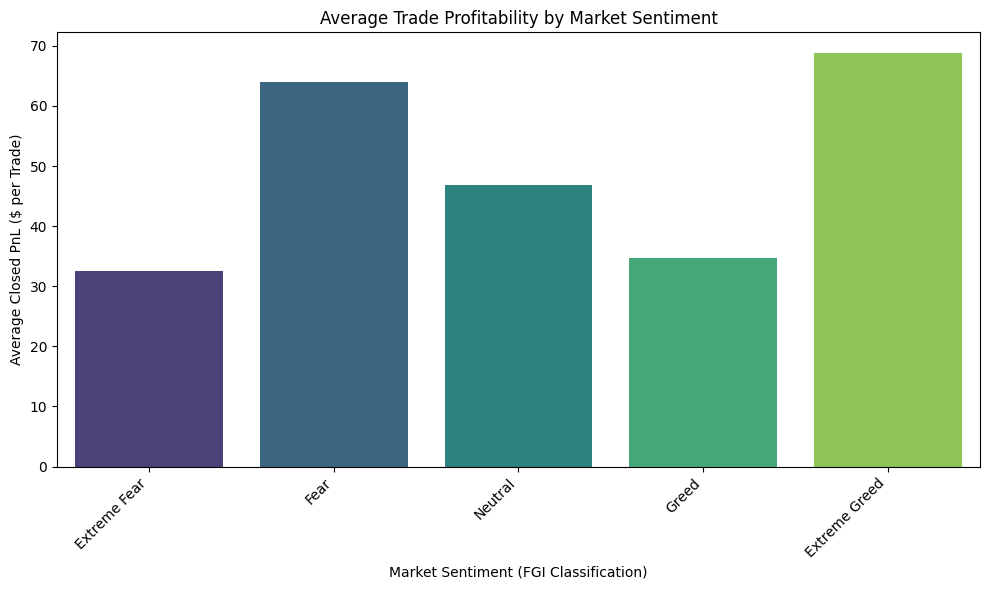

In [6]:
# Updated Code for Step 6: Visualize Profitability (Average PnL)
plt.figure(figsize=(10, 6))

# FIX: Assign the x variable ('FGI_Classification') to the 'hue' parameter
# and set legend=False as recommended by the warning.
sns.barplot(
    x='FGI_Classification',
    y='Average_Closed_PnL',
    data=df_agg,
    palette='viridis',
    hue='FGI_Classification', # <-- NEW: Explicitly define hue
    legend=False             # <-- NEW: Suppress the unnecessary legend
)

plt.title('Average Trade Profitability by Market Sentiment')
plt.xlabel('Market Sentiment (FGI Classification)')
plt.ylabel('Average Closed PnL ($ per Trade)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot (It already worked, but running this again will use the new code)
plt.savefig('outputs/avg_pnl_by_sentiment.png')


print("Chart 1 saved: outputs/avg_pnl_by_sentiment.png ")

# **Visualize Activity (Total Volume).**

Chart 2 saved: outputs/total_volume_by_sentiment.png


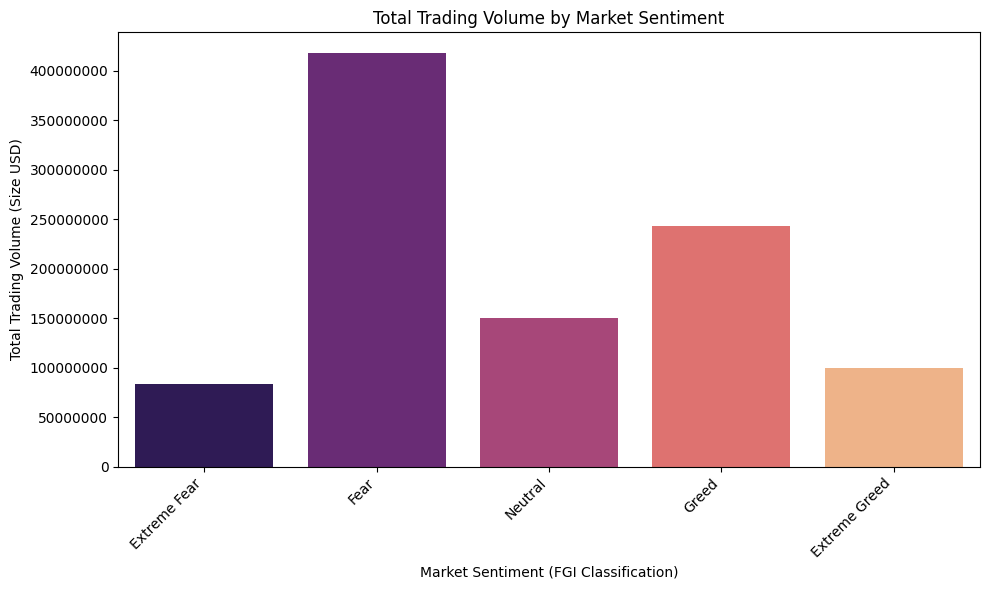

In [7]:
# Updated Code for Step 7: Visualize Activity (Total Volume)

# Import plotting libraries (if not already imported)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# FIX: Applying best practice by assigning 'hue' to eliminate the FutureWarning
sns.barplot(
    x='FGI_Classification',
    y='Total_Volume_USD',
    data=df_agg,
    palette='magma',
    hue='FGI_Classification', # Explicitly define hue
    legend=False             # Suppress the unnecessary legend
)

plt.title('Total Trading Volume by Market Sentiment')
plt.xlabel('Market Sentiment (FGI Classification)')
plt.ylabel('Total Trading Volume (Size USD)')
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y') # Important: keeps the large monetary values readable
plt.tight_layout()

# Save the plot to the required 'outputs' directory
plt.savefig('outputs/total_volume_by_sentiment.png')

print("Chart 2 saved: outputs/total_volume_by_sentiment.png")